In [1]:
!pip install pyspark

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql import Window


In [3]:
spark = SparkSession.builder \
    .appName("Agriculture Data Processing") \
    .getOrCreate()

In [4]:
# Suppress warnings (equivalent to warnings.filterwarnings('ignore'))
spark.sparkContext.setLogLevel("ERROR")


-------------------------------------
### 1. DATA LOADING AND MERGING
-------------------------------------
##### STEP 1: DATA LOADING AND MERGING

In [5]:
# Load all datasets
fertilizer_df = spark.read.csv('Fertilizer.csv', header=True, inferSchema=True)
crop_yield_df = spark.read.csv('crop_yield.csv', header=True, inferSchema=True)
rainfall_df = spark.read.csv('rainfall_validation.csv', header=True, inferSchema=True)
temperature_df = spark.read.csv('final_temperature.csv', header=True, inferSchema=True)

print("    - All datasets loaded.")

print(f"    - Fertilizer shape: {fertilizer_df.count()}, {len(fertilizer_df.columns)}")
print(f"    - Crop yield shape: {crop_yield_df.count()}, {len(crop_yield_df.columns)}")
print(f"    - Rainfall shape: {rainfall_df.count()}, {len(rainfall_df.columns)}")
print(f"    - Temperature shape: {temperature_df.count()}, {len(temperature_df.columns)}")


    - All datasets loaded.
    - Fertilizer shape: 1843, 5
    - Crop yield shape: 246091, 7
    - Rainfall shape: 180, 14
    - Temperature shape: 33, 5


In [6]:
# Standardize text data function
def standardize_text(df, cols):
    for col_name in cols:
        if col_name in df.columns:
            df = df.withColumn(col_name, F.lower(F.trim(F.col(col_name))))
    return df
# Apply text standardization
crop_yield_df = standardize_text(crop_yield_df, ['State_Name', 'District_Name', 'Crop', 'Season'])
rainfall_df = standardize_text(rainfall_df, ['SUBDIVISION'])
temperature_df = standardize_text(temperature_df, ['States'])
fertilizer_df = standardize_text(fertilizer_df, ['Crop'])

print("    - Text data standardized (lowercase, stripped whitespace).")


    - Text data standardized (lowercase, stripped whitespace).


In [7]:
# State name mapping for consistency
state_name_mapping = {
    'andaman & nicobar islands': 'andaman and nicobar islands',
    'dadra & nagar haveli': 'dadra and nagar haveli',
    'jammu & kashmir': 'jammu and kashmir',
    'n.i. karnataka': 'north interior karnataka',
    's.i. karnataka': 'south interior karnataka',
    'rayalaseema': 'andhra pradesh',
    'coastal andhra pradesh': 'andhra pradesh',
    'telangana': 'andhra pradesh',
    'puducherry': 'pondicherry',
    'daman & diu': 'daman and diu',
    'uttaranchal': 'uttarakhand'
}
# Replace state names
for old_name, new_name in state_name_mapping.items():
    rainfall_df = rainfall_df.withColumn('SUBDIVISION', F.when(F.col('SUBDIVISION') == old_name, new_name).otherwise(F.col('SUBDIVISION')))
    temperature_df = temperature_df.withColumn('States', F.when(F.col('States') == old_name, new_name).otherwise(F.col('States')))

print("    - State names mapped for consistency.")

    - State names mapped for consistency.


In [8]:
# Process rainfall data
rainfall_df = rainfall_df.withColumnRenamed('SUBDIVISION', 'State_Name') \
    .withColumnRenamed('YEAR', 'Crop_Year') \
    .withColumn('kharif_rainfall', (F.col('JUN') + F.col('JUL') + F.col('AUG') + F.col('SEP'))) \
    .withColumn('rabi_rainfall', (F.col('OCT') + F.col('NOV') + F.col('DEC') + F.col('JAN'))) \
    .withColumn('summer_rainfall', (F.col('FEB') + F.col('MAR') + F.col('APR') + F.col('MAY'))) \
    .withColumn('yearly_rainfall', F.expr('JAN + FEB + MAR + APR + MAY + JUN + JUL + AUG + SEP + OCT + NOV + DEC'))

processed_rainfall_df = rainfall_df.select('State_Name', 'Crop_Year', 'kharif_rainfall', 'rabi_rainfall', 'summer_rainfall', 'yearly_rainfall')

print("    - Rainfall data processed (seasonal/yearly sums calculated).")


    - Rainfall data processed (seasonal/yearly sums calculated).


In [9]:
# Merge datasets
df_merged = crop_yield_df.join(processed_rainfall_df, on=['State_Name', 'Crop_Year'], how='left')
print(f"    - Shape after merging rainfall: {df_merged.count()}, {len(df_merged.columns)}")

temperature_df = temperature_df.withColumnRenamed('States', 'State_Name')
df_merged = df_merged.join(temperature_df, on='State_Name', how='left')
print(f"    - Shape after merging temperature: {df_merged.count()}, {len(df_merged.columns)}")

df_merged = df_merged.join(fertilizer_df, on='Crop', how='left')
print(f"    - Shape after merging fertilizer: {df_merged.count()}, {len(df_merged.columns)}")


    - Shape after merging rainfall: 248760, 11
    - Shape after merging temperature: 261057, 15
    - Shape after merging fertilizer: 1726005, 19


In [10]:
df_merged.show()

+-------------------+--------------------+---------+-------------+------+------+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+------------------+----+----+----+----+
|               Crop|          State_Name|Crop_Year|District_Name|Season|  Area|Production|kharif_rainfall|rabi_rainfall|summer_rainfall|yearly_rainfall|kharif_temp|rabi_temp|summer_temp|       yearly_temp|   N|   P|   K|  pH|
+-------------------+--------------------+---------+-------------+------+------+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+------------------+----+----+----+----+
|           arecanut|andaman and nicob...|     2000|     nicobars|kharif|1254.0|    2000.0|           NULL|         NULL|           NULL|           NULL|       27.0|     26.6|       27.8|27.036363636363635| 100|  40| 140|5.82|
|           arecanut|andaman and nicob...|     2000|     nicobars|kharif|1254.0|    2000.0| 

-------------------------------------
### 2. DATA QUALITY CHECKS AND CLEANING
-------------------------------------

In [11]:
# Check for missing values
print("\nMissing values before cleaning:")
missing_values = df_merged.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_merged.columns])
missing_values.show()


Missing values before cleaning:
+----+----------+---------+-------------+------+----+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+-----------+------+------+------+------+
|Crop|State_Name|Crop_Year|District_Name|Season|Area|Production|kharif_rainfall|rabi_rainfall|summer_rainfall|yearly_rainfall|kharif_temp|rabi_temp|summer_temp|yearly_temp|     N|     P|     K|    pH|
+----+----------+---------+-------------+------+----+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+-----------+------+------+------+------+
|   0|         0|        0|            0|     0|   0|     18677|        1552997|      1552997|        1552997|        1552997|      41031|    41031|      41031|      41031|179671|179671|179671|179671|
+----+----------+---------+-------------+------+----+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+---

In [12]:
# Handle missing values
# For numerical columns, fill with grouped means
numerical_cols = ['Area', 'Production', 'kharif_rainfall', 'rabi_rainfall',
                  'summer_rainfall', 'yearly_rainfall', 'kharif_temp',
                  'rabi_temp', 'summer_temp', 'yearly_temp', 'N', 'P', 'K', 'pH']

for col_name in numerical_cols:
    if col_name in df_merged.columns:
        if 'rainfall' in col_name:
            group_cols = ['State_Name', 'Crop_Year']
        elif 'temp' in col_name:
            group_cols = ['State_Name']
        elif col_name in ['N', 'P', 'K', 'pH']:
            group_cols = ['Crop']
        else:
            group_cols = ['State_Name', 'Crop', 'Season']

        df_merged = df_merged.withColumn(col_name, F.when(F.col(col_name).isNull(),
            F.mean(col_name).over(Window.partitionBy(*group_cols))).otherwise(F.col(col_name)))

        # Fill remaining with global mean
        global_mean = df_merged.select(F.mean(col_name)).first()[0]
        df_merged = df_merged.withColumn(col_name, F.when(F.col(col_name).isNull(), global_mean).otherwise(F.col(col_name)))

In [13]:
# For categorical columns, fill with mode or 'unknown'
categorical_cols = ['State_Name', 'District_Name', 'Crop', 'Season']
for col_name in categorical_cols:
    if col_name in df_merged.columns:
        # Calculate mode
        mode_value = df_merged.select(col_name).na.drop().agg(F.mode(col_name)).first()[0]

        # Fill missing values with mode or 'unknown' if mode is None
        df_merged = df_merged.withColumn(col_name,
                                          F.when(F.col(col_name).isNull(), mode_value if mode_value is not None else 'unknown')
                                          .otherwise(F.col(col_name)))

print("    - Missing values handled for categorical columns.")


    - Missing values handled for categorical columns.


In [14]:
print("\nMissing values after cleaning:")
missing_values_after = df_merged.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_merged.columns])
missing_values_after.show()


Missing values after cleaning:
+----+----------+---------+-------------+------+----+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+-----------+---+---+---+---+
|Crop|State_Name|Crop_Year|District_Name|Season|Area|Production|kharif_rainfall|rabi_rainfall|summer_rainfall|yearly_rainfall|kharif_temp|rabi_temp|summer_temp|yearly_temp|  N|  P|  K| pH|
+----+----------+---------+-------------+------+----+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+-----------+---+---+---+---+
|   0|         0|        0|            0|     0|   0|         0|              0|            0|              0|              0|          0|        0|          0|          0|  0|  0|  0|  0|
+----+----------+---------+-------------+------+----+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+-----------+---+---+---+---+



In [ ]:
df_merged.printSchema()

In [15]:
# Drop the _c0 column from the DataFrame
df_merged = df_merged.drop('_c0')
print("    - Column '_c0' dropped from the DataFrame.")

    - Column '_c0' dropped from the DataFrame.


In [16]:
df_merged.printSchema()

root
 |-- Crop: string (nullable = true)
 |-- State_Name: string (nullable = true)
 |-- Crop_Year: integer (nullable = true)
 |-- District_Name: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Area: double (nullable = true)
 |-- Production: double (nullable = true)
 |-- kharif_rainfall: double (nullable = true)
 |-- rabi_rainfall: double (nullable = true)
 |-- summer_rainfall: double (nullable = true)
 |-- yearly_rainfall: double (nullable = true)
 |-- kharif_temp: double (nullable = true)
 |-- rabi_temp: double (nullable = true)
 |-- summer_temp: double (nullable = true)
 |-- yearly_temp: double (nullable = true)
 |-- N: double (nullable = true)
 |-- P: double (nullable = true)
 |-- K: double (nullable = true)
 |-- pH: double (nullable = true)



In [17]:
# Remove duplicates if any
df_merged = df_merged.dropDuplicates()
print(f"\nNumber of duplicates after cleaning: {df_merged.count() - df_merged.distinct().count()}")


Number of duplicates after cleaning: 0


In [18]:
df_merged.show()

+---------+--------------+---------+--------------+----------+-------+----------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|     Crop|    State_Name|Crop_Year| District_Name|    Season|   Area|Production|  kharif_rainfall|     rabi_rainfall|   summer_rainfall|   yearly_rainfall|       kharif_temp|         rabi_temp|       summer_temp|       yearly_temp|                N|                P|                 K|                pH|
+---------+--------------+---------+--------------+----------+-------+----------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------------+------------------+
|arhar/tur|andhra pradesh|     2001|    srikakulam|    kharif| 1395.0|     813.

In [19]:
# Save intermediate merged data
df_initial_merged = df_merged

df_initial_merged.toPandas().to_csv('agripredict_initial_merged_data.csv', index=False)
print("    - Intermediate merged data saved.")

    - Intermediate merged data saved.


-------------------------------------
### 3. FEATURE ENGINEERING
-------------------------------------

In [20]:
# Create relevant rainfall and temperature based on season
conditions = [
    df_merged['Season'].contains('kharif'),
    df_merged['Season'].contains('rabi'),
    df_merged['Season'].contains('summer') | df_merged['Season'].contains('zaid'),
    df_merged['Season'].contains('whole year')
]

choices = [
    df_merged['kharif_rainfall'],
    df_merged['rabi_rainfall'],
    df_merged['summer_rainfall'],
    df_merged['yearly_rainfall']
]

df_merged = df_merged.withColumn('relevant_rainfall', F.when(conditions[0], choices[0])
                                  .when(conditions[1], choices[1])
                                  .when(conditions[2], choices[2])
                                  .when(conditions[3], choices[3])
                                  .otherwise(None))

conditions_temp = [
    df_merged['Season'].contains('kharif'),
    df_merged['Season'].contains('rabi'),
    df_merged['Season'].contains('summer') | df_merged['Season'].contains('zaid'),
    df_merged['Season'].contains('whole year')
]

choices_temp = [
    df_merged['kharif_temp'],
    df_merged['rabi_temp'],
    df_merged['summer_temp'],
    df_merged['yearly_temp']
]

df_merged = df_merged.withColumn('relevant_temperature', F.when(conditions_temp[0], choices_temp[0])
                                  .when(conditions_temp[1], choices_temp[1])
                                  .when(conditions_temp[2], choices_temp[2])
                                  .when(conditions_temp[3], choices_temp[3])
                                  .otherwise(None))

print("    - Created 'relevant_rainfall' and 'relevant_temperature' features.")


    - Created 'relevant_rainfall' and 'relevant_temperature' features.


In [21]:
# Calculate yield (production/area)
df_merged = df_merged.withColumn('Area', F.when(F.col('Area') == 0, None).otherwise(F.col('Area')))
df_merged = df_merged.withColumn('Yield_ton_per_hec', F.col('Production') / F.col('Area'))
df_merged = df_merged.withColumn('Yield_ton_per_hec', F.when(F.col('Yield_ton_per_hec').isNull(), None).otherwise(F.col('Yield_ton_per_hec')))


In [22]:
# Fill yield NaNs with crop-season averages
df_merged = df_merged.withColumn('Yield_ton_per_hec', F.when(F.col('Yield_ton_per_hec').isNull(),
    F.mean('Yield_ton_per_hec').over(Window.partitionBy('Crop', 'Season'))).otherwise(F.col('Yield_ton_per_hec')))

# Fill remaining with global mean
global_yield_mean = df_merged.agg(F.mean('Yield_ton_per_hec')).first()[0]
df_merged = df_merged.withColumn('Yield_ton_per_hec', F.when(F.col('Yield_ton_per_hec').isNull(), global_yield_mean).otherwise(F.col('Yield_ton_per_hec')))

print("    - Calculated 'Yield_ton_per_hec'.")

    - Calculated 'Yield_ton_per_hec'.


In [23]:
# Create interaction features
df_merged = df_merged.withColumn('rainfall_temp_interaction', F.col('relevant_rainfall') * F.col('relevant_temperature'))
df_merged = df_merged.withColumn('NPK_ratio', F.col('N') / (F.col('P') + F.col('K') + 1e-6))

print("    - Created interaction features.")


    - Created interaction features.


In [24]:
# Create lag features
df_merged = df_merged.sort(['State_Name', 'District_Name', 'Crop', 'Season', 'Crop_Year'])
df_merged = df_merged.withColumn('lagged_production_1yr',
                                  F.lag('Production', 1).over(Window.partitionBy('State_Name', 'District_Name', 'Crop', 'Season').orderBy('Crop_Year')))
df_merged = df_merged.withColumn('lagged_yield_1yr',
                                  F.lag('Yield_ton_per_hec', 1).over(Window.partitionBy('State_Name', 'District_Name', 'Crop', 'Season').orderBy('Crop_Year')))


In [25]:
# Fill lag features with mean values
df_merged = df_merged.withColumn('lagged_production_1yr', F.when(F.col('lagged_production_1yr').isNull(),
    F.mean('lagged_production_1yr').over(Window.partitionBy('Crop', 'Season'))).otherwise(F.col('lagged_production_1yr')))
df_merged = df_merged.withColumn('lagged_yield_1yr', F.when(F.col('lagged_yield_1yr').isNull(),
    F.mean('lagged_yield_1yr').over(Window.partitionBy('Crop', 'Season'))).otherwise(F.col('lagged_yield_1yr')))

print("    - Created lag features.")


In [26]:
df_merged.show()

+-------------------+----------+---------+---------------+----------+-------+----------+-----------------+-----------------+------------------+------------------+------------------+---------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-------------------------+------------------+---------------------+----------------+
|               Crop|State_Name|Crop_Year|  District_Name|    Season|   Area|Production|  kharif_rainfall|    rabi_rainfall|   summer_rainfall|   yearly_rainfall|       kharif_temp|rabi_temp|       summer_temp|      yearly_temp|                N|                P|                 K|                pH| relevant_rainfall|relevant_temperature| Yield_ton_per_hec|rainfall_temp_interaction|         NPK_ratio|lagged_production_1yr|lagged_yield_1yr|
+-------------------+----------+---------+---------------+----------+-------+----------+-----------------+--

In [29]:
print("\nMissing values:")
missing_values_after = df_merged.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_merged.columns])
missing_values_after.show()


Missing values after cleaning:
+----+----------+---------+-------------+------+----+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+-----------+---+---+---+---+-----------------+--------------------+-----------------+-------------------------+---------+---------------------+----------------+
|Crop|State_Name|Crop_Year|District_Name|Season|Area|Production|kharif_rainfall|rabi_rainfall|summer_rainfall|yearly_rainfall|kharif_temp|rabi_temp|summer_temp|yearly_temp|  N|  P|  K| pH|relevant_rainfall|relevant_temperature|Yield_ton_per_hec|rainfall_temp_interaction|NPK_ratio|lagged_production_1yr|lagged_yield_1yr|
+----+----------+---------+-------------+------+----+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+-----------+---+---+---+---+-----------------+--------------------+-----------------+-------------------------+---------+---------------------+----------------+
|   0

In [30]:
# Step 1: Fill missing values in relevant_rainfall and relevant_temperature
# using coalesce() which returns the first non-null value
df_merged = df_merged.withColumn(
    'relevant_rainfall',
    coalesce(col('relevant_rainfall'), col('yearly_rainfall'))
).withColumn(
    'relevant_temperature',
    coalesce(col('relevant_temperature'), col('yearly_temp'))
)

In [31]:
# Step 2: Create the rainfall_temp_interaction column
df_merged = df_merged.withColumn(
    'rainfall_temp_interaction',
    col('relevant_rainfall') * col('relevant_temperature')
)

In [32]:
# Step 3: Fill missing values for lagged columns using grouped mean
# Define a window partitioned by 'Crop' and 'Season'
window_spec = Window.partitionBy('Crop', 'Season')

for col_name in ['lagged_production_1yr', 'lagged_yield_1yr']:
    # Calculate the mean for the group within the window
    mean_val = mean(col(col_name)).over(window_spec)

    # Fill NaN values with the group mean
    df_merged = df_merged.withColumn(
        col_name,
        coalesce(col(col_name), mean_val)
    )

# Fill any remaining NaN values with the overall mean
for col_name in ['lagged_production_1yr', 'lagged_yield_1yr']:
    # Calculate the overall mean
    overall_mean = df_merged.select(mean(col(col_name))).first()[0]

    # Fill remaining NaN values with the overall mean
    df_merged = df_merged.na.fill({col_name: overall_mean})


In [33]:
print("\nMissing values:")
missing_values_after = df_merged.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_merged.columns])
missing_values_after.show()


Missing values after cleaning:
+----+----------+---------+-------------+------+----+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+-----------+---+---+---+---+-----------------+--------------------+-----------------+-------------------------+---------+---------------------+----------------+
|Crop|State_Name|Crop_Year|District_Name|Season|Area|Production|kharif_rainfall|rabi_rainfall|summer_rainfall|yearly_rainfall|kharif_temp|rabi_temp|summer_temp|yearly_temp|  N|  P|  K| pH|relevant_rainfall|relevant_temperature|Yield_ton_per_hec|rainfall_temp_interaction|NPK_ratio|lagged_production_1yr|lagged_yield_1yr|
+----+----------+---------+-------------+------+----+----------+---------------+-------------+---------------+---------------+-----------+---------+-----------+-----------+---+---+---+---+-----------------+--------------------+-----------------+-------------------------+---------+---------------------+----------------+
|   0

In [35]:
# Save intermediate merged data
df_featured_merged = df_merged

df_featured_merged.toPandas().to_csv('agripredict_featured_merged_data.csv', index=False)
print("    - Merged data saved.")

    - Merged data saved.


-----------------------------------------
### 4. OUTLIER DETECTION AND TREATMENT
-----------------------------------------

In [36]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [37]:
df_merged = pd.read_csv("agripredict_featured_merged_data.csv")

In [38]:
# 1. SETUP & DATA PREPARATION

numerical_cols_for_outliers = ['Area', 'Production', 'kharif_rainfall', 'rabi_rainfall',
                              'summer_rainfall', 'yearly_rainfall', 'kharif_temp',
                              'rabi_temp', 'summer_temp', 'yearly_temp', 'N', 'P', 'K',
                              'pH', 'Yield_ton_per_hec', 'rainfall_temp_interaction',
                              'NPK_ratio', 'lagged_production_1yr', 'lagged_yield_1yr']


In [39]:
# Create feature matrix
X = df_merged[numerical_cols_for_outliers].copy()

# Scale data (critical for distance-based methods)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [40]:
# 2. OUTLIER DETECTION WITH ISOLATION FOREST

# Configure Isolation Forest
iso_forest = IsolationForest(
    n_estimators=200,       # More trees = more stable results
    max_samples=256,        # Process 256 samples per tree (memory efficient)
    contamination='auto',   # Auto-detect outlier proportion
    random_state=42,
    n_jobs=-1,              # Use all CPU cores
    verbose=1               # Show progress
)

In [41]:
# Fit model (this may take 5-15 mins for 1.7M rows)
print("Fitting Isolation Forest...")
iso_forest.fit(X_scaled)

Fitting Isolation Forest...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    4.7s finished


IsolationForest(max_samples=256, n_estimators=200, n_jobs=-1, random_state=42,
                verbose=1)

In [42]:
# 5. Predict outliers (-1 for outliers, 1 for inliers)
outlier_preds = iso_forest.predict(X_scaled)


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   13.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.1s finished


In [43]:
# Predict outliers (-1 for outliers, 1 for inliers)
outlier_scores = iso_forest.decision_function(X_scaled)  # Higher = more normal
outlier_preds = iso_forest.predict(X_scaled)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   13.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:   12.4s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:   12.5s finished


In [44]:
# Add results to DataFrame
df_merged['outlier_score'] = outlier_scores
df_merged['is_outlier'] = np.where(outlier_preds == -1, 1, 0)

In [45]:
# Calculate robust bounds from inliers only
inlier_df = df_merged[df_merged['is_outlier'] == 0]
percentiles = inlier_df[numerical_cols_for_outliers].quantile([0.01, 0.99])

print("\nApplying outlier treatment...")
for col in numerical_cols_for_outliers:
    lower = percentiles.loc[0.01, col]
    upper = percentiles.loc[0.99, col]

    # Cap outliers
    df_merged[col] = np.where(
        (df_merged['is_outlier'] == 1) & (df_merged[col] < lower), lower,
        np.where(
            (df_merged['is_outlier'] == 1) & (df_merged[col] > upper), upper,
            df_merged[col]
        )
    )
    print(f"Processed {col}: [{lower:.2f}, {upper:.2f}]")



Applying outlier treatment...
Processed Area: [1.00, 210215.00]
Processed Production: [0.00, 584278.00]
Processed kharif_rainfall: [519.80, 1102.00]
Processed rabi_rainfall: [41.30, 467.30]
Processed summer_rainfall: [49.20, 145.00]
Processed yearly_rainfall: [746.40, 1348.70]
Processed kharif_temp: [22.07, 35.35]
Processed rabi_temp: [14.60, 27.60]
Processed summer_temp: [20.36, 35.34]
Processed yearly_temp: [18.78, 29.96]
Processed N: [20.00, 180.00]
Processed P: [10.00, 75.00]
Processed K: [20.00, 140.00]
Processed pH: [4.82, 6.62]
Processed Yield_ton_per_hec: [0.00, 66.89]
Processed rainfall_temp_interaction: [3018.91, 36965.05]
Processed NPK_ratio: [0.16, 1.33]
Processed lagged_production_1yr: [0.00, 610000.00]
Processed lagged_yield_1yr: [0.00, 78.73]


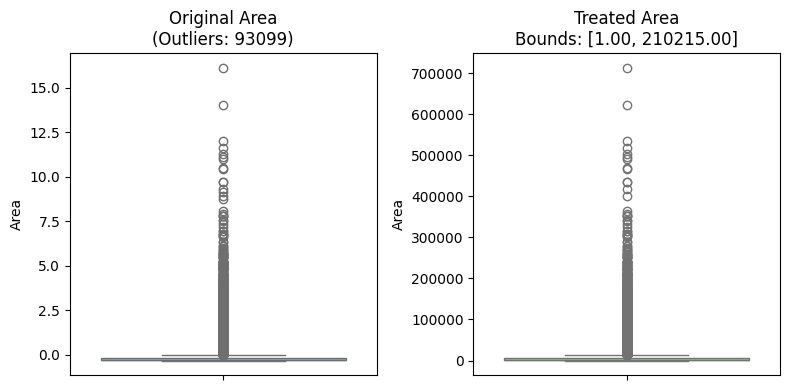

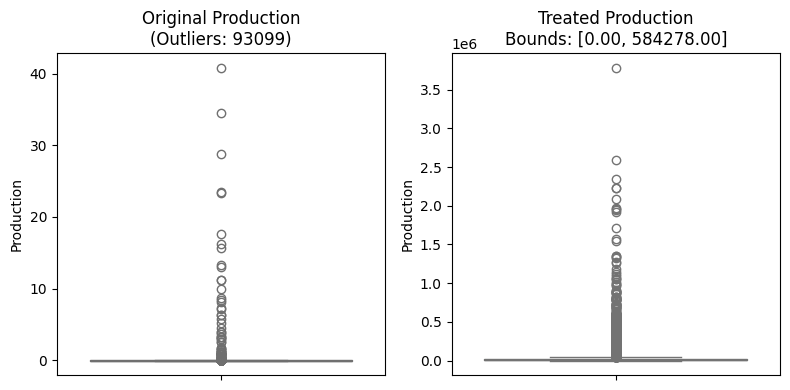

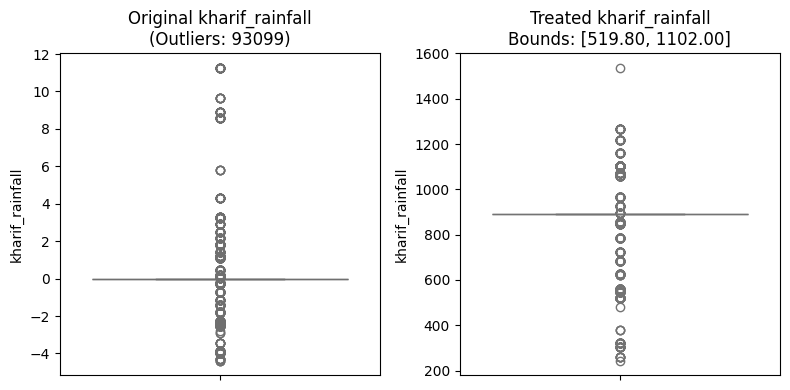

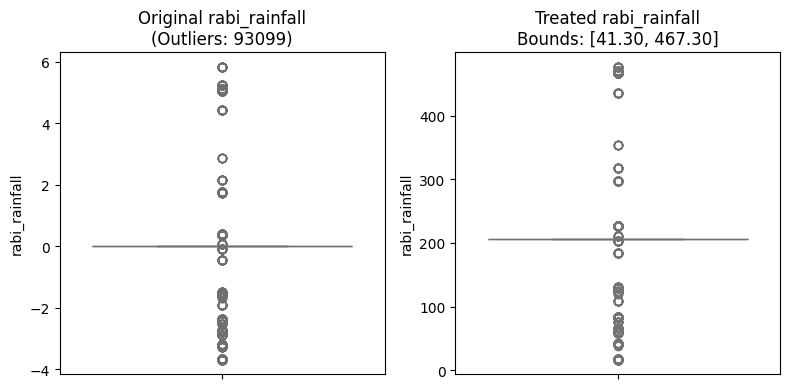

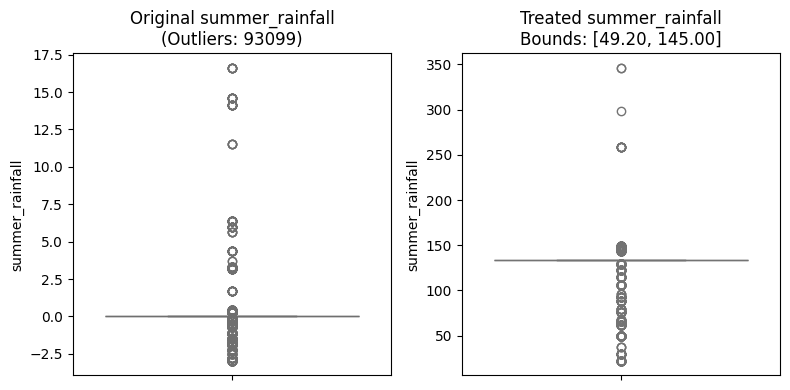

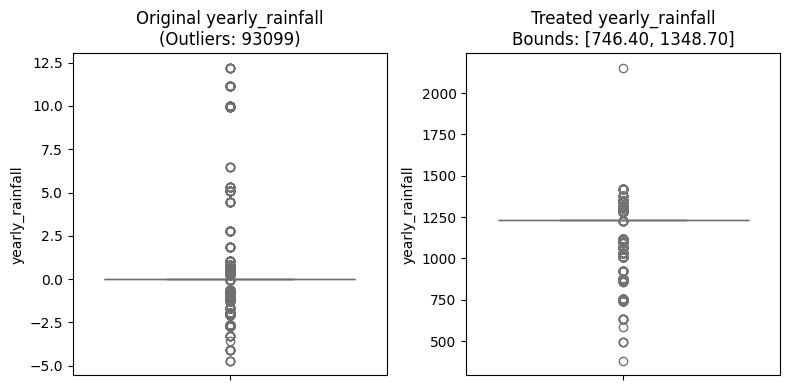

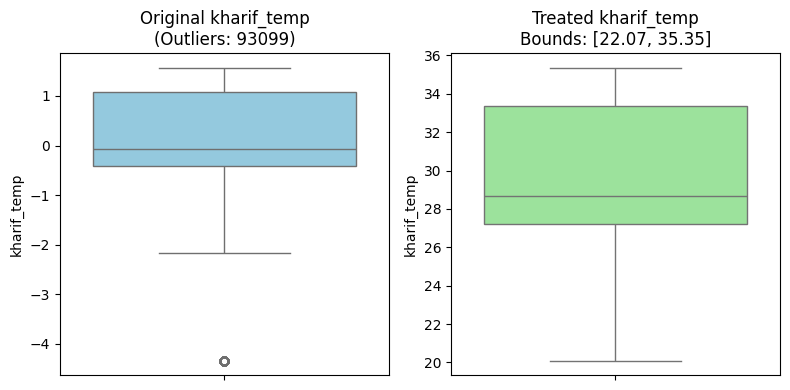

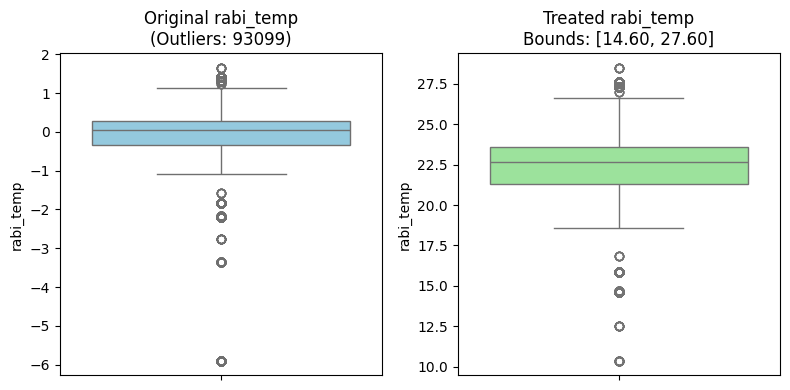

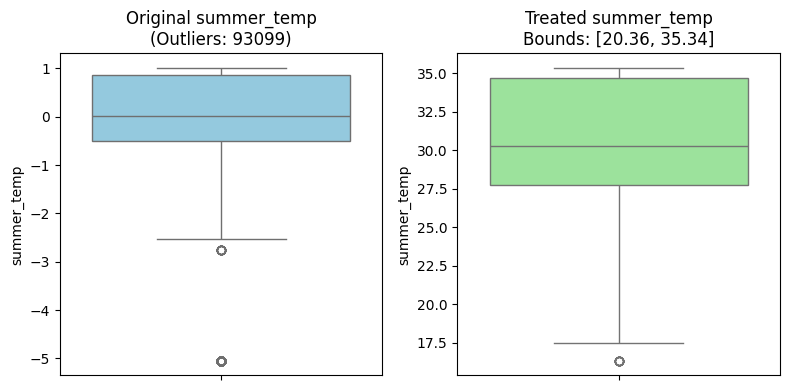

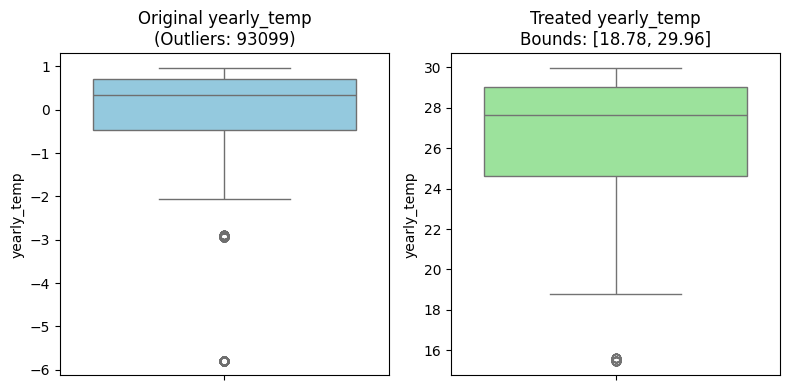

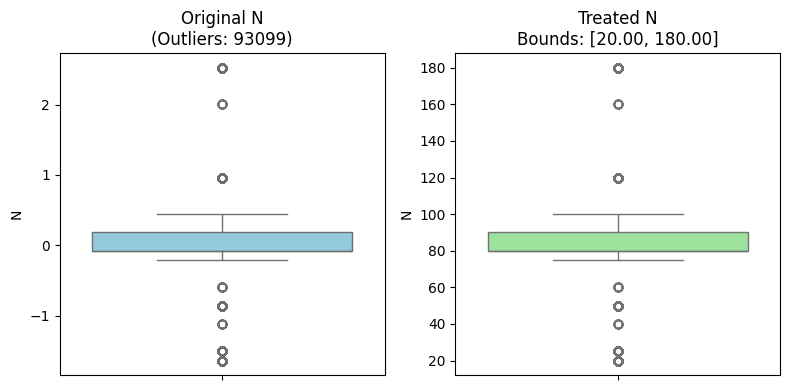

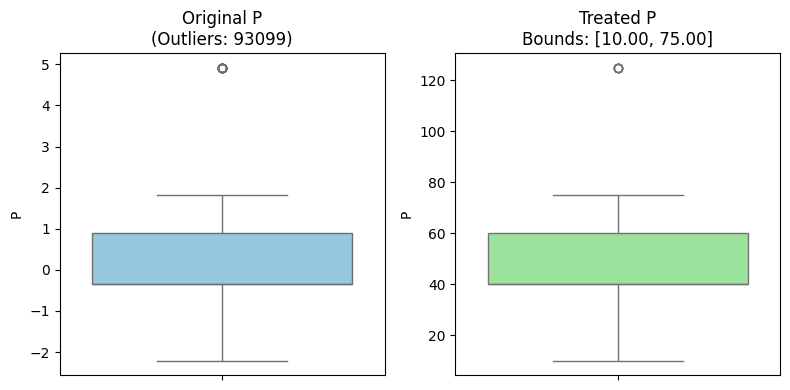

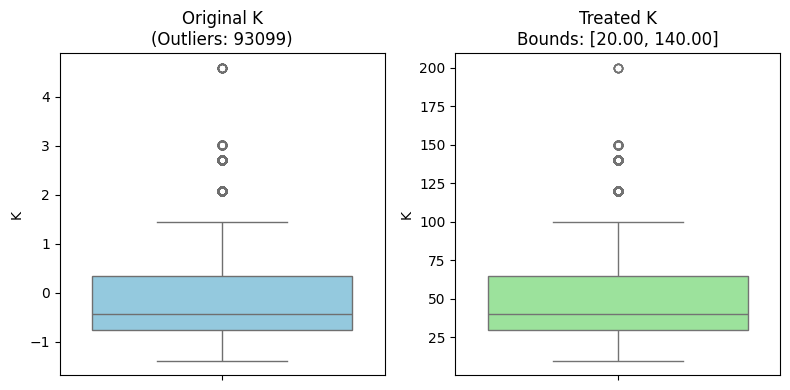

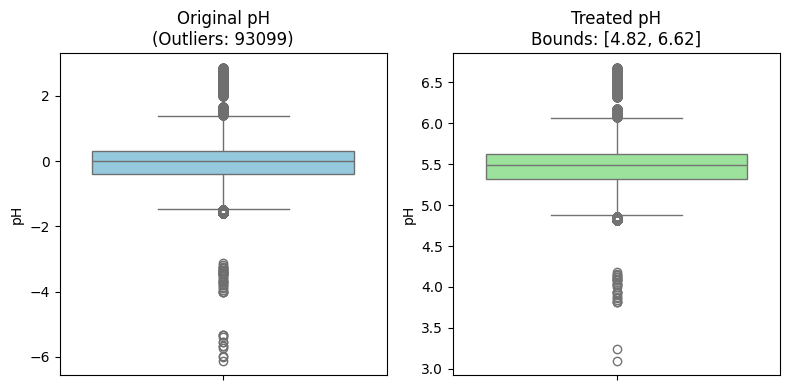

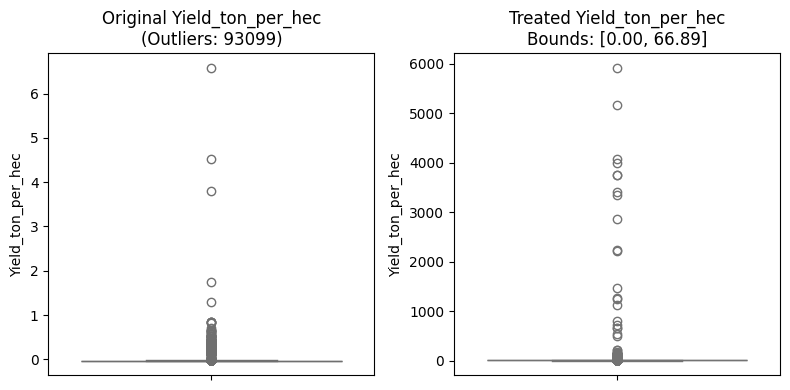

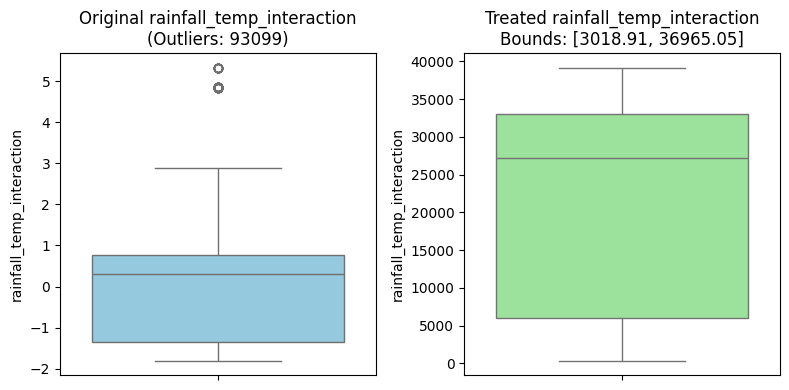

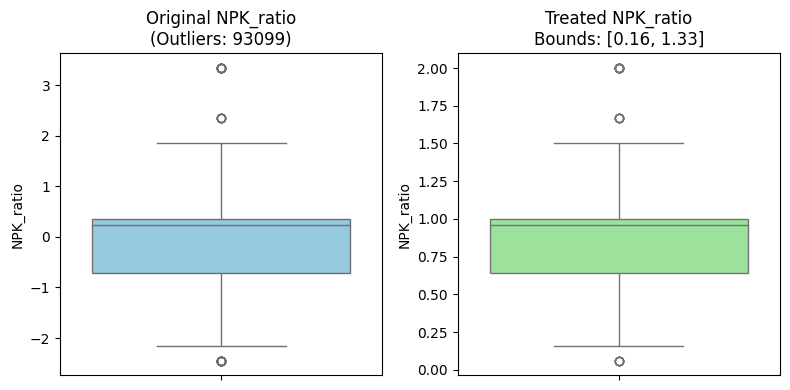

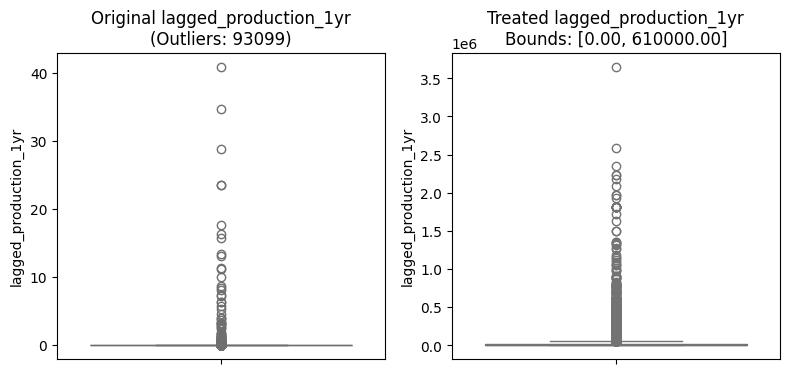

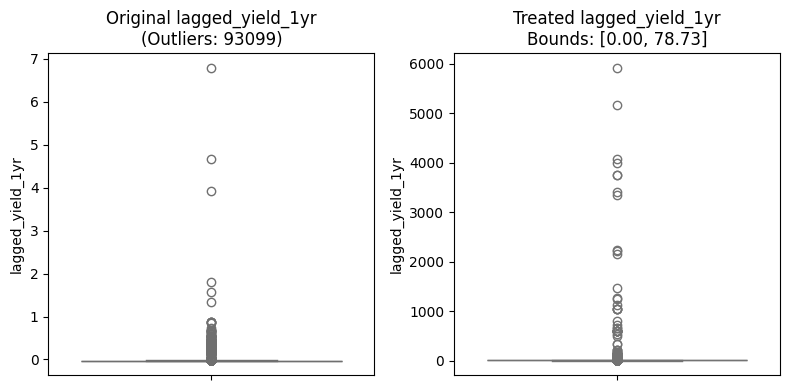

In [48]:
# Sample 0.5% of data for visualization
sample_size = 0.005
sample_df = df_merged.sample(frac=sample_size, random_state=42)
original_sample = pd.DataFrame(X_scaled, columns=numerical_cols_for_outliers).sample(frac=sample_size, random_state=42)

# Plot settings
# plt.style.use('seaborn') # Removed unavailable style
plt.rcParams['figure.figsize'] = (8, 4)

# Calculate outlier counts per column from df_merged
outlier_counts = df_merged[df_merged['is_outlier'] == 1][numerical_cols_for_outliers].count()


# Plot first 5 columns for demonstration
for col in numerical_cols_for_outliers:
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Before treatment
    sns.boxplot(y=original_sample[col], ax=ax1, color='skyblue')
    ax1.set_title(f'Original {col}\n(Outliers: {outlier_counts.get(col, 0)})')

    # After treatment
    sns.boxplot(y=sample_df[col], ax=ax2, color='lightgreen')
    ax2.set_title(f'Treated {col}\nBounds: [{percentiles.loc[0.01, col]:.2f}, {percentiles.loc[0.99, col]:.2f}]')

    plt.tight_layout()
    plt.show()

-----------------------------------------
### 5. EXPLORATORY DATA ANALYSIS (EDA)
-----------------------------------------


##### STEP 5: EXPLORATORY DATA ANALYSIS (EDA)


1. Distribution of Numerical Variables:


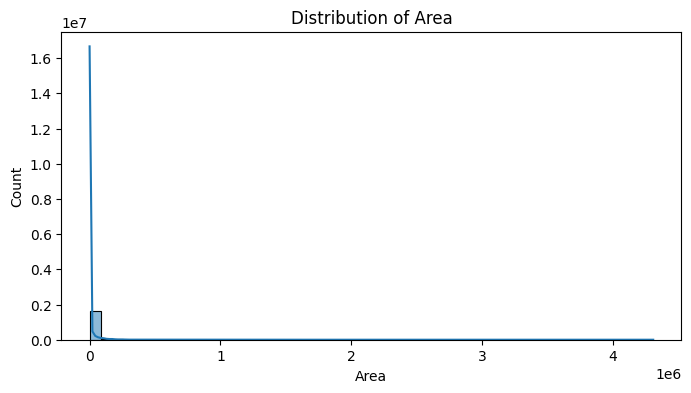

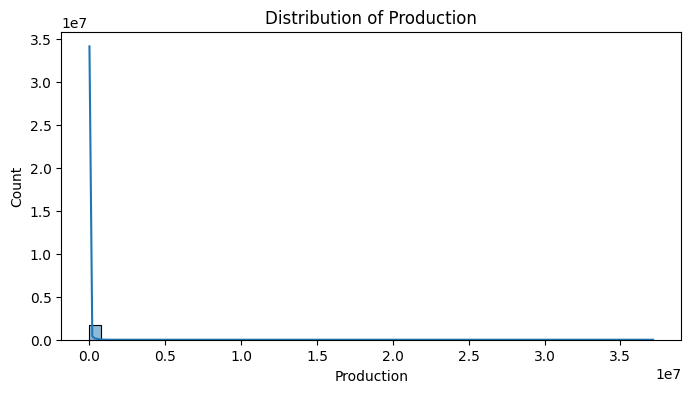

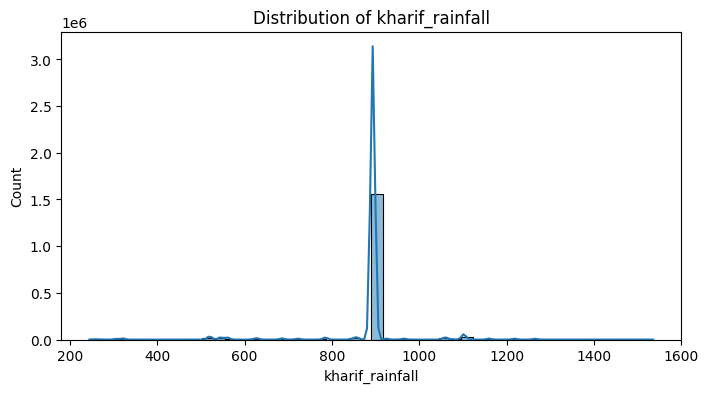

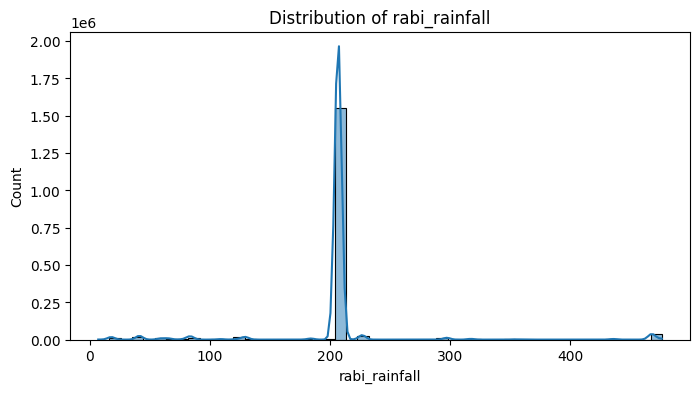

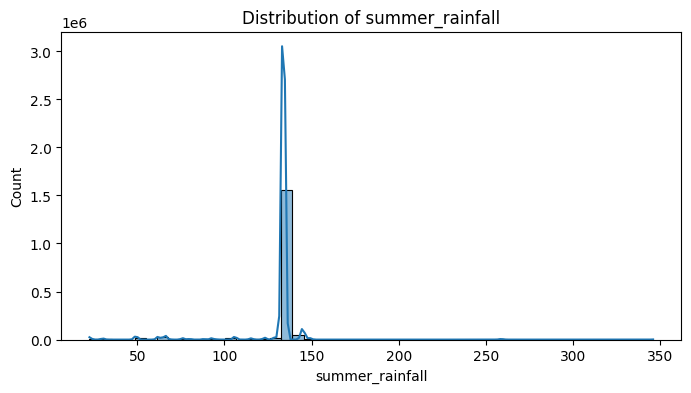

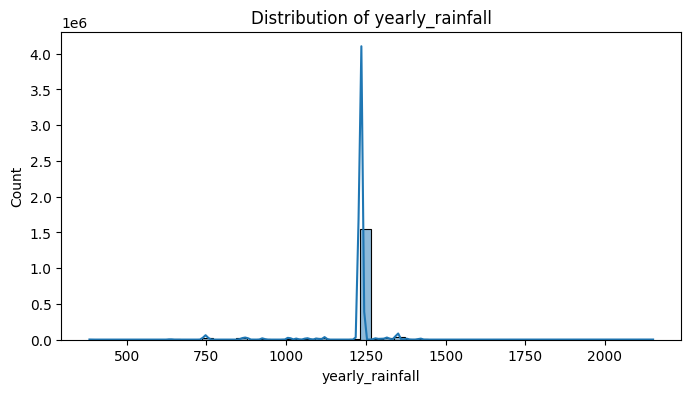

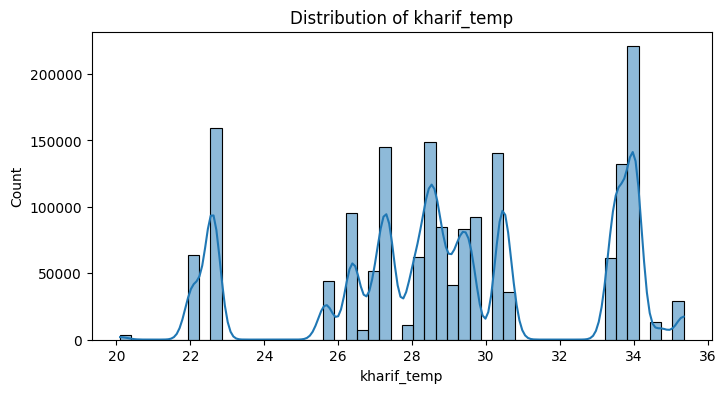

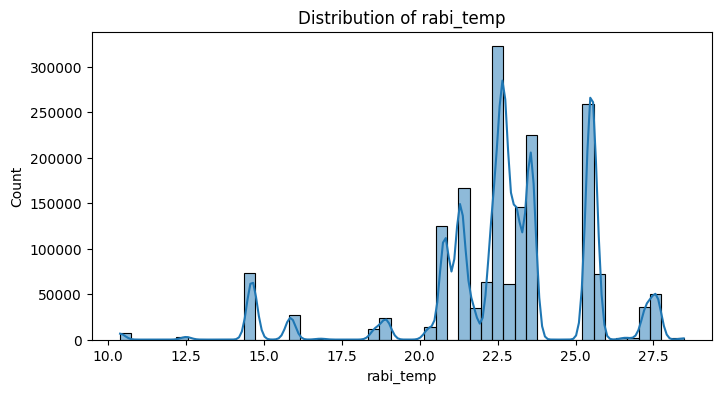

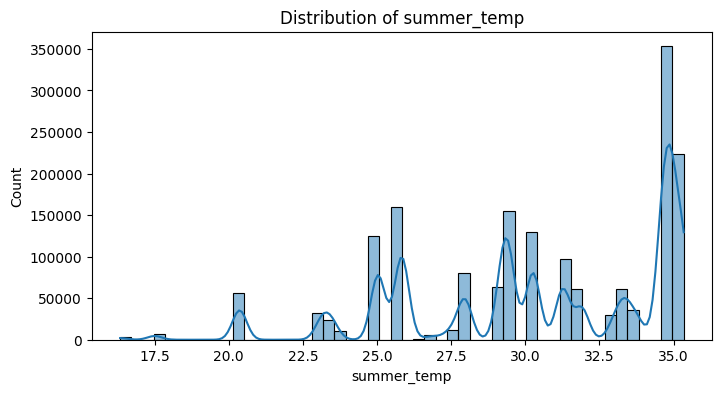

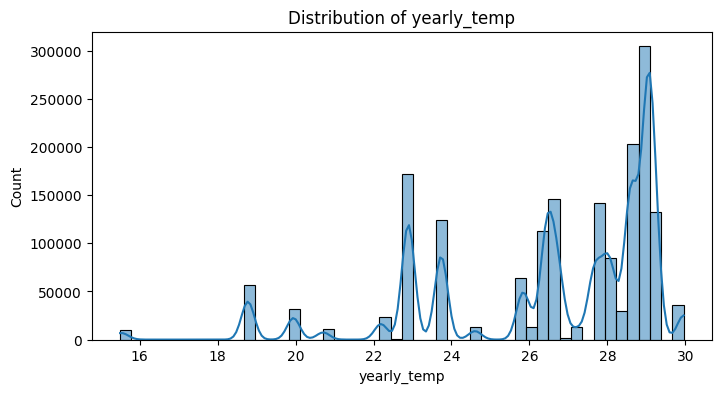

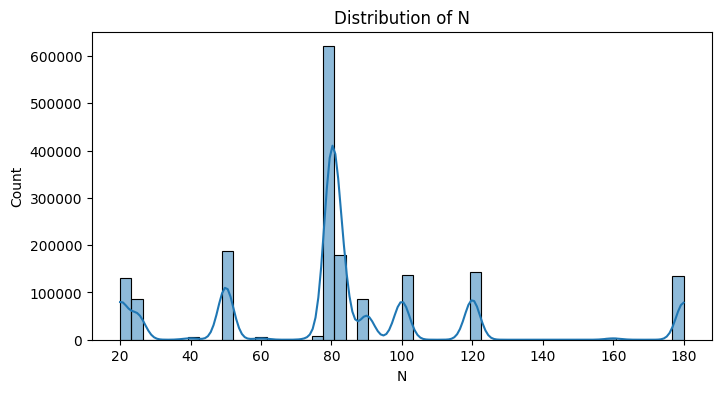

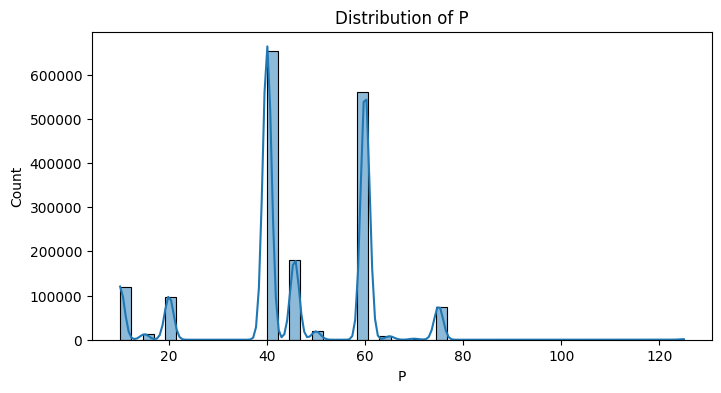

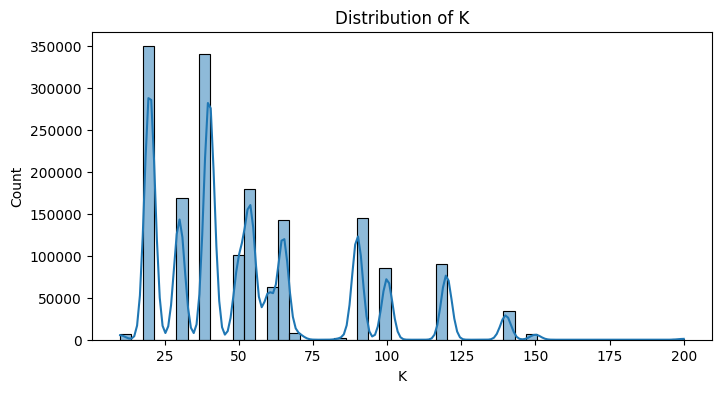

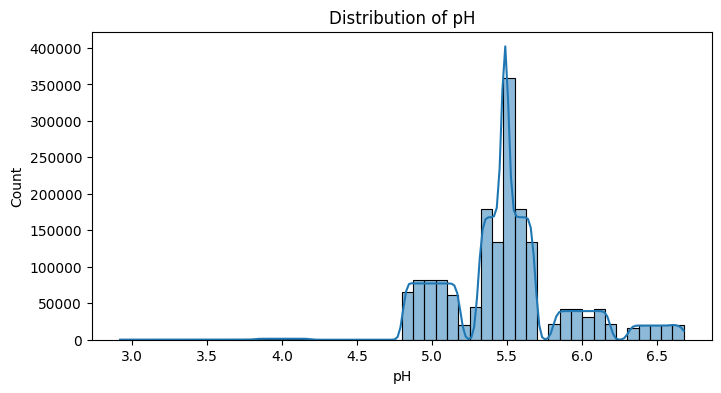

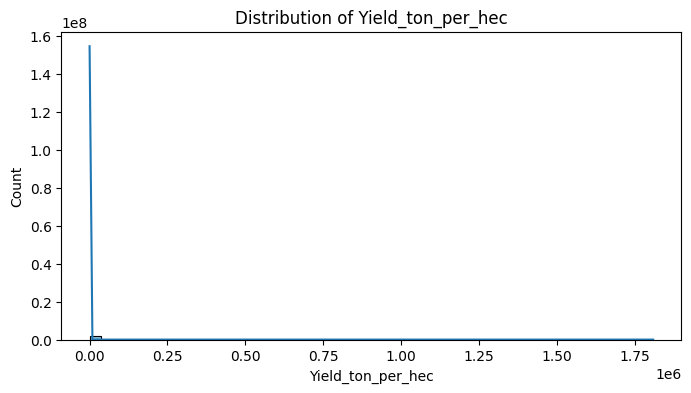

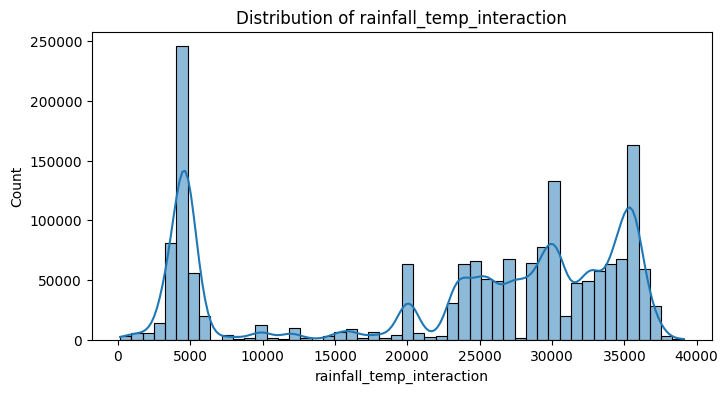

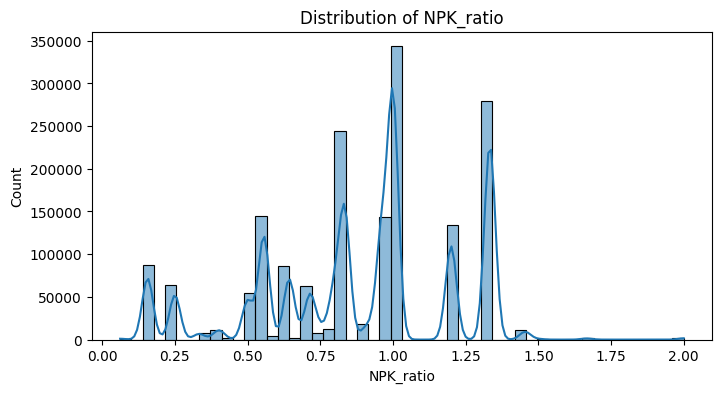

In [51]:
# 1. Distribution of numerical variables
numerical_cols_for_eda = ['Area', 'Production', 'kharif_rainfall', 'rabi_rainfall',
                         'summer_rainfall', 'yearly_rainfall', 'kharif_temp',
                         'rabi_temp', 'summer_temp', 'yearly_temp', 'N', 'P', 'K',
                         'pH', 'Yield_ton_per_hec', 'rainfall_temp_interaction',
                         'NPK_ratio']

print("\n1. Distribution of Numerical Variables:")
for col in numerical_cols_for_eda:
    if col in df_merged.columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(df_merged[col], kde=True, bins=50)
        plt.title(f'Distribution of {col}')
        plt.show()


2. Distribution of Categorical Variables:


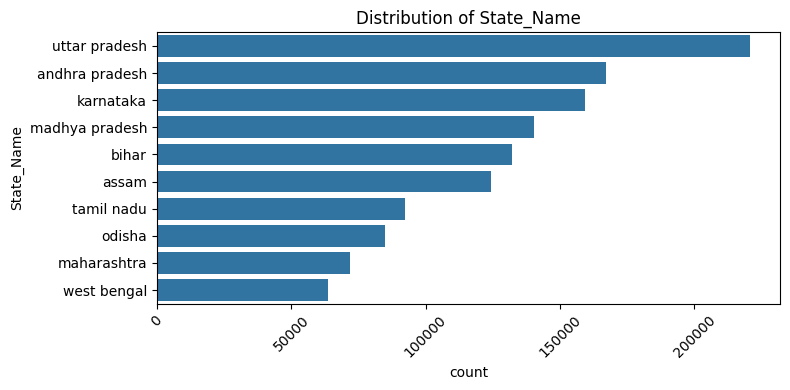

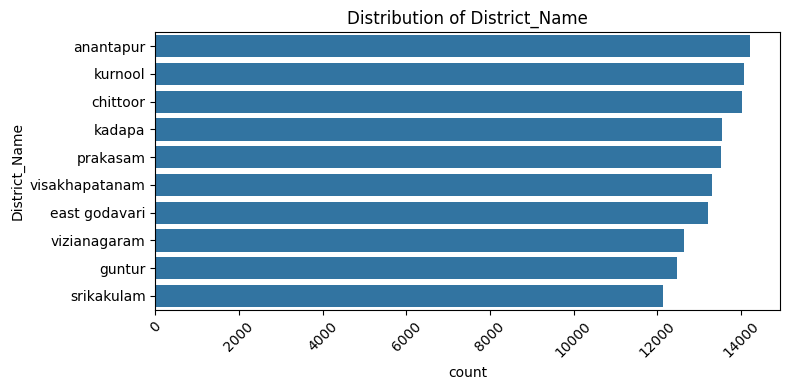

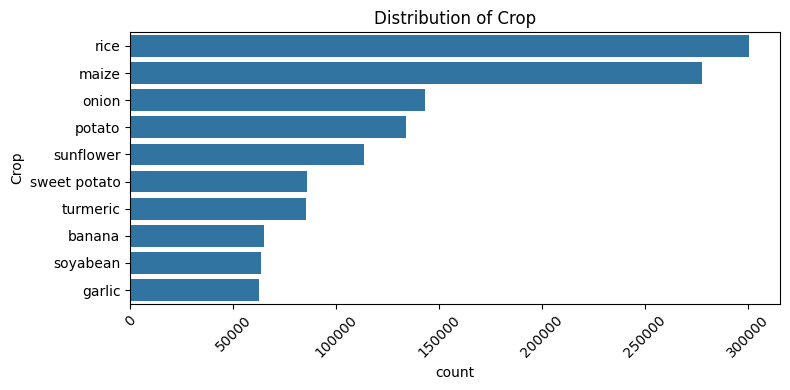

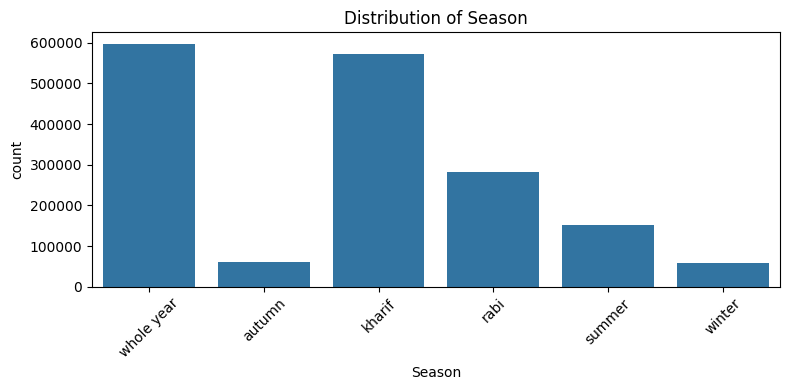

In [52]:
# 2. Categorical variable distributions
print("\n2. Distribution of Categorical Variables:")
categorical_cols_for_eda = ['State_Name', 'District_Name', 'Crop', 'Season']
for col in categorical_cols_for_eda:
    if col in df_merged.columns:
        plt.figure(figsize=(8, 4))
        if df_merged[col].nunique() > 10:  # For columns with many categories
            top_categories = df_merged[col].value_counts().nlargest(10).index
            sns.countplot(y=col, data=df_merged, order=top_categories)
        else:
            sns.countplot(x=col, data=df_merged)
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


3. Correlation Analysis:


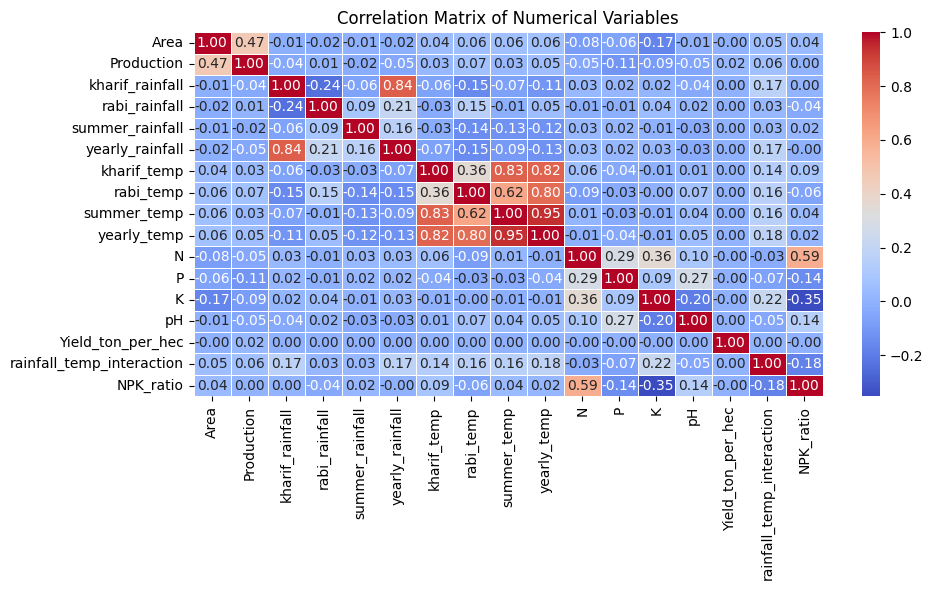

In [53]:
# 3. Correlation analysis
print("\n3. Correlation Analysis:")
plt.figure(figsize=(10, 6))
corr_matrix = df_merged[numerical_cols_for_eda].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()


4. Time Series Analysis:


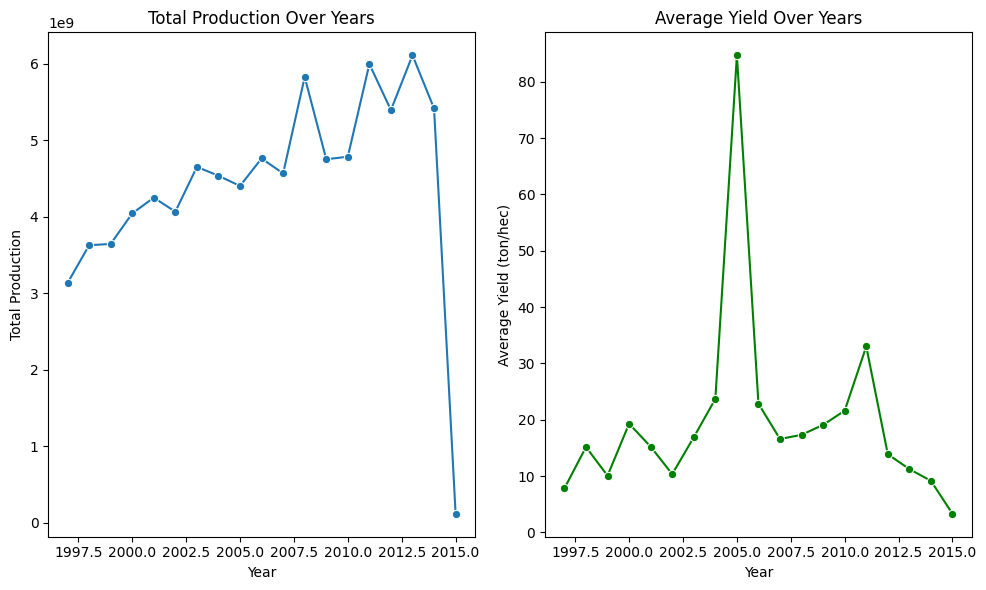

In [54]:
# 4. Time series analysis of yield and production
print("\n4. Time Series Analysis:")
if 'Crop_Year' in df_merged.columns:
    yearly_summary = df_merged.groupby('Crop_Year').agg({
        'Production': 'sum',
        'Yield_ton_per_hec': 'mean'
    }).reset_index()

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    sns.lineplot(x='Crop_Year', y='Production', data=yearly_summary, marker='o')
    plt.title('Total Production Over Years')
    plt.xlabel('Year')
    plt.ylabel('Total Production')

    plt.subplot(1, 2, 2)
    sns.lineplot(x='Crop_Year', y='Yield_ton_per_hec', data=yearly_summary, marker='o', color='green')
    plt.title('Average Yield Over Years')
    plt.xlabel('Year')
    plt.ylabel('Average Yield (ton/hec)')
    plt.tight_layout()
    plt.show()


5. Feature-Yield Relationships:


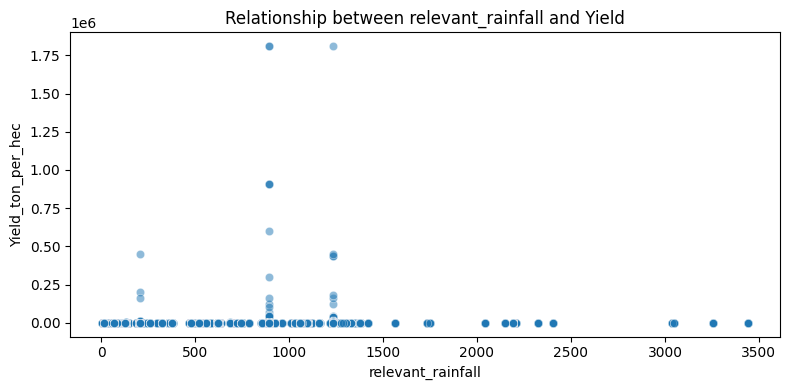

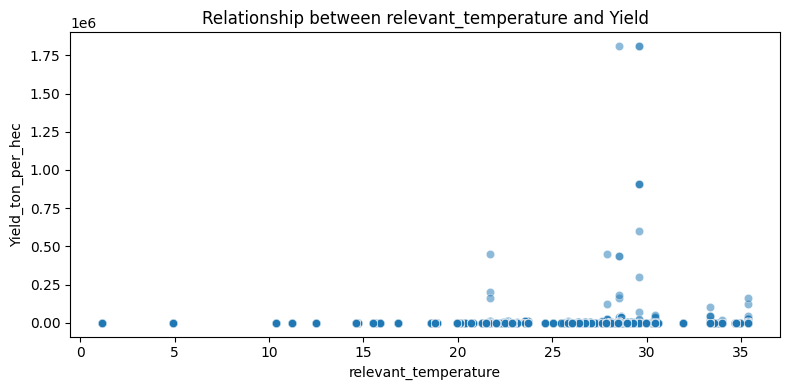

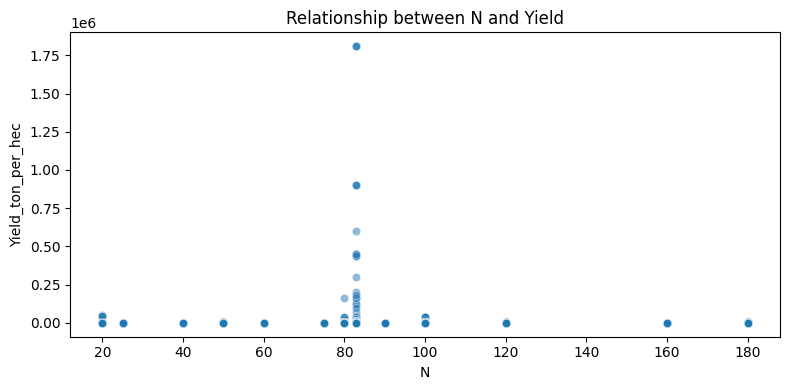

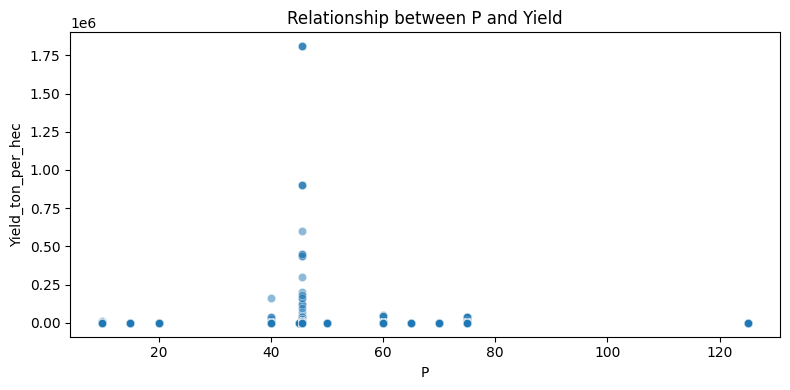

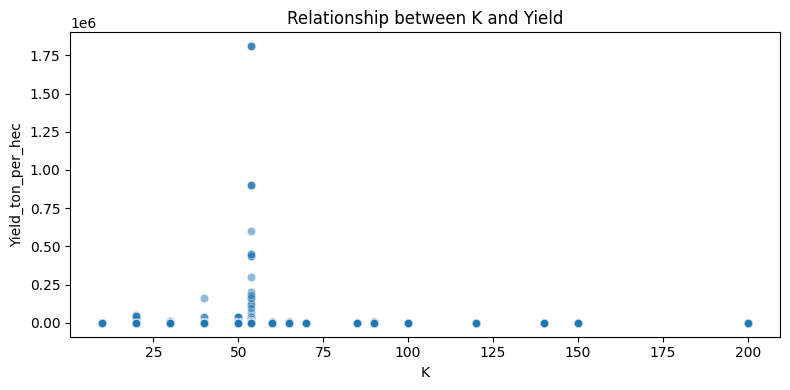

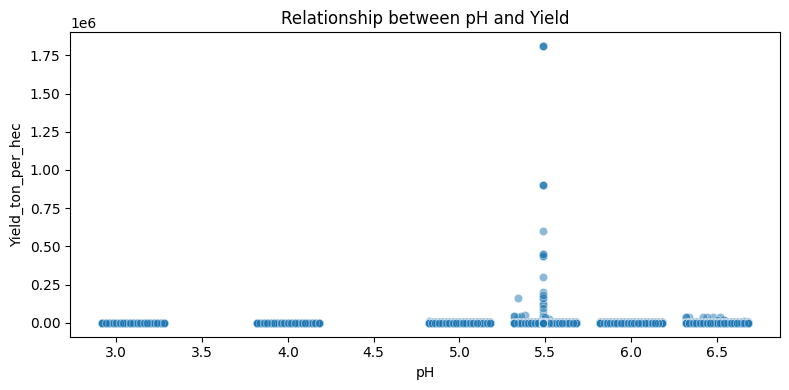

In [55]:
# 5. Relationship between key features and yield
print("\n5. Feature-Yield Relationships:")
key_features = ['relevant_rainfall', 'relevant_temperature', 'N', 'P', 'K', 'pH']
for feature in key_features:
    if feature in df_merged.columns:
        plt.figure(figsize=(8, 4))
        sns.scatterplot(x=feature, y='Yield_ton_per_hec', data=df_merged, alpha=0.5)
        plt.title(f'Relationship between {feature} and Yield')
        plt.tight_layout()
        plt.show()

--------------------------------------------------------------------------------
### 6. FINAL PROCESSED DATA SAVE
--------------------------------------------------------------------------------

##### FINAL PROCESSED DATA SAVE

In [58]:

# Select final columns to keep
final_columns = ['State_Name', 'District_Name', 'Crop', 'Season', 'Crop_Year',
                'Area', 'Production', 'kharif_rainfall', 'rabi_rainfall',
                'summer_rainfall', 'yearly_rainfall', 'kharif_temp', 'rabi_temp',
                'summer_temp', 'yearly_temp', 'N', 'P', 'K', 'pH',
                'relevant_rainfall', 'relevant_temperature', 'rainfall_temp_interaction',
                'NPK_ratio', 'lagged_production_1yr', 'lagged_yield_1yr',
                'Yield_ton_per_hec']

df_final = df_merged[final_columns]



In [60]:
df_final.head(20)

,State_Name,District_Name,Crop,Season,Crop_Year,Area,Production,kharif_rainfall,rabi_rainfall,summer_rainfall,...,P,K,pH,relevant_rainfall,relevant_temperature,rainfall_temp_interaction,NPK_ratio,lagged_production_1yr,lagged_yield_1yr,Yield_ton_per_hec
0,karnataka,chamarajanagar,arcanut (processed),whole year,2002,279.0,198.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,1233.963059,22.890909,28246.536204,0.833949,1.809643e+06,587.489209,0.709677
1,karnataka,chitradurga,arcanut (processed),whole year,2002,13452.0,12958.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,1233.963059,22.890909,28246.536204,0.833949,1.809643e+06,587.489209,0.963277
2,karnataka,dharwad,arcanut (processed),whole year,2002,10.0,14.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,1233.963059,22.890909,28246.536204,0.833949,1.809643e+06,587.489209,1.400000
3,karnataka,kolar,arcanut (processed),whole year,2002,72.0,101.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,1233.963059,22.890909,28246.536204,0.833949,1.809643e+06,587.489209,1.402778
4,karnataka,mandya,arcanut (processed),whole year,2002,804.0,1124.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,1233.963059,22.890909,28246.536204,0.833949,1.809643e+06,587.489209,1.398010
5,karnataka,tumkur,arcanut (processed),whole year,2002,14226.0,17450.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,1233.963059,22.890909,28246.536204,0.833949,1.809643e+06,587.489209,1.226627
6,karnataka,uttar kannad,arcanut (processed),whole year,2002,11824.0,16072.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,1233.963059,22.890909,28246.536204,0.833949,1.809643e+06,587.489209,1.359269
7,karnataka,bagalkot,arcanut (processed),whole year,2002,6.0,8.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,1233.963059,22.890909,28246.536204,0.833949,1.809643e+06,587.489209,1.333333
8,karnataka,bangalore rural,arcanut (processed),whole year,2002,1904.0,2663.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,1233.963059,22.890909,28246.536204,0.833949,1.809643e+06,587.489209,1.398634
9,karnataka,bellary,arcanut (processed),whole year,2002,30.0,43.0,893.375234,206.774431,133.813394,...,45.617612,53.883285,5.488273,1233.963059,22.890909,28246.536204,0.833949,1.809643e+06,587.489209,1.433333


In [61]:
# Save final processed data
df_final.to_csv('agripredict_final_processed_data.csv', index=False)
print("    - Final processed data saved to 'agripredict_final_processed_data.csv'")

print("\n=== PROCESSING COMPLETE ===")

    - Final processed data saved to 'agripredict_final_processed_data.csv'

=== PROCESSING COMPLETE ===


# MODEL